In [550]:
%matplotlib inline
%pylab inline
import sympy as sym
import pylab as pl
import numpy as np
import numpy.polynomial.polynomial as n_poly
import numpy.polynomial.legendre as leg

import scipy
from scipy.interpolate import *
from scipy.integrate import *

from mpl_toolkits.mplot3d import Axes3D

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# EXERCISE 1

### Equispaced and Chebishev

In [551]:
l_infty = lambda y: abs(y).max()

def lagrangian_interpolation_matrix(x,q):
    Ln = np.zeros((len(q), len(x)))
    for i in range(len(q)):
        Ln[i] = np.product([(x-q[j])/(q[i]-q[j]) for j in range(len(q)) if j != i], axis=0)
    return Ln

def der(f,n):
    assert len(f.free_symbols) == 1, "I can only do this for single variable functions..."
    t = f.free_symbols.pop()
    return sym.lambdify(t, f.diff(t, n), 'numpy')

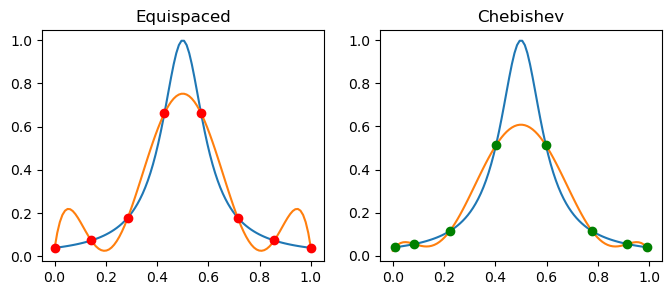

In [552]:
# Now construct a symbolic function...
t = sym.var('t')
fs = 1 / (1 + 100 * (t - 0.5)**2) # Runge function
fs_prime = fs.diff(t, 1)
f_prime = sym.lambdify(t,fs_prime, 'numpy')

f = der(fs,0)

n = 7
x = np.linspace(0,1,100)
q = np.linspace(0,1,n+1)

#Equispaced points
Ln = lagrangian_interpolation_matrix(x,q)

fig, axes = pl.subplots(1, 2, figsize=(8,3))
      
axes[0].plot(x, f(x))
axes[0].plot(x, Ln.T.dot(f(q)))
axes[0].plot(q, f(q), 'ro')
axes[0].set_title("Equispaced")


# Chebyshev points
x = np.linspace(0,1,100)
generator = lambda x,n: x.min()+(x.max()-x.min())/2*(np.polynomial.chebyshev.chebgauss(n)[0]+1)
# interpolation points
q1 = generator(x,n+1)

# The interpolation matrix
Lnc = lagrangian_interpolation_matrix(x,q1)

axes[1].plot(x, f(x))
axes[1].plot(x, Lnc.T.dot(f(q1)))
axes[1].plot(q1, f(q1), 'go')
axes[1].set_title("Chebishev");

show()

### Solving M Matrix

In [553]:
def define_lagrange_basis_set(q):
    n = q.shape[0]
    L = [n_poly.Polynomial.fromroots([xj for xj in q if xj != q[i]]) for i in range(n)]
    L = [L[i]/L[i](q[i]) for i in range(n)]
    return L

deg = 7
x = np.linspace(0,1,100)
q = np.linspace(0,1,deg+1)
Nq = deg+1

p,w = leg.leggauss(Nq)
w = .5 * w
p = .5*(p+1)

W = np.diag(w)

L = define_lagrange_basis_set(q)

# L = Ln

B = np.zeros((0,Nq))
for l in L:
    B = np.vstack([B,l(p)])
    
M = B.dot(W.dot(B.T))


# g = lambda x: sin(x**2)

f = der(fs,0)
p = p.reshape((p.shape[0],1))
func = f(p)

G = B.dot(W.dot(func))

u = np.linalg.solve(M, G)

def get_interpolating_function(LL,ui):
    def func(LL,ui,x):
        acc = 0
        for L,u in zip(LL,ui):
            #print(L,u)
            acc+=u*L(x)
        return acc
    return lambda x : func(LL,ui,x)

I = get_interpolating_function(L,u)

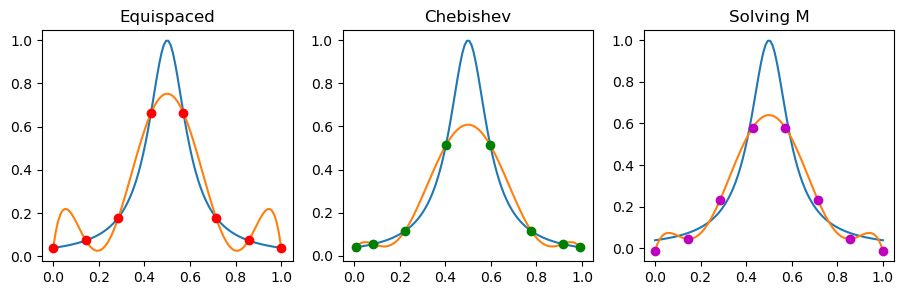

In [554]:

x = linspace(0,1,100)

fig, axes = pl.subplots(1, 3, figsize=(11,3))

axes[0].plot(x, f(x))
axes[0].plot(x, Ln.T.dot(f(q)))
axes[0].plot(q, f(q), 'ro')
axes[0].set_title("Equispaced")

axes[1].plot(x, f(x))
axes[1].plot(x, Lnc.T.dot(f(q1)))
axes[1].plot(q1, f(q1), 'go')
axes[1].set_title("Chebishev");

axes[2].plot(x, f(x))
axes[2].plot(x, I(x))
axes[2].plot(q, u, 'mo')
axes[2].set_title("Solving M");

show()

In [555]:
# define w
w = lambda x,q: np.product([x-q[i] for i in range(len(q))], axis=0)

In [556]:
def check_errors(x, fs, n, generator=lambda x,n: np.linspace(x.min(),x.max(),n)):
    """
    Check the error for the interpolation obtained by calling 
    q = generator(x,i)
    for each i in the range(2,n).
    
    The default generator uses equispaced points.
    """
    points = range(2,n)
    UpperEstimate = []
    ActualError = []
    
    f = der(fs, 0)
    
    for n in points:
        q = generator(x,n)

        Ln = lagrangian_interpolation_matrix(x,q)
        ActualError.append(l_infty(f(x) - Ln.T.dot(f(q))))

        fp = der(fs, len(q))
        nth_der = l_infty(fp(x))

        w_infty = l_infty(w(x,q))

        UpperEstimate.append(nth_der*w_infty/np.math.factorial(len(q)))
    
    return (points, UpperEstimate, ActualError)

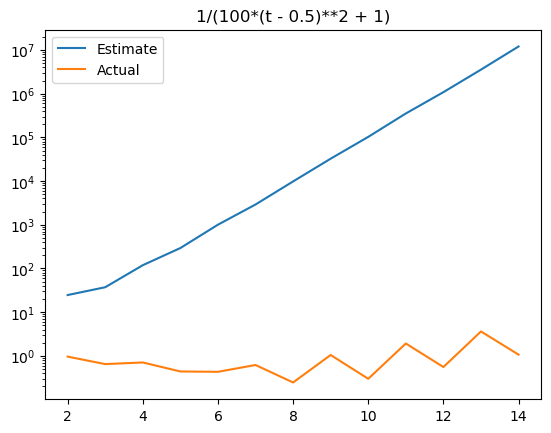

In [557]:
p, u, e = check_errors(x, fs, 15)
    
_ = pl.semilogy(p, np.c_[u, e])
pl.title(str(fs))
pl.legend(['Estimate', 'Actual'])
pl.show()

# EXERCISE 2

# 2D Case

In [558]:
def der(f,n):
    assert len(f.free_symbols) == 1, "I can only do this for single variable functions..."
    t = f.free_symbols.pop()
    return sym.lambdify(t, f.diff(t, n), 'numpy')

l_infty = lambda y: abs(y).max()

def define_lagrange_basis_set(q):
    n = q.shape[0]
    L = [n_poly.Polynomial.fromroots([xj for xj in q if xj != q[i]]) for i in range(n)]
    L = [L[i]/L[i](q[i]) for i in range(n)]
    return L

def lagrangian_interpolation_matrix(x,q):
    Ln = np.zeros((len(q), len(x)))
    for i in range(len(q)):
        Ln[i] = np.product([(x-q[j])/(q[i]-q[j]) for j in range(len(q)) if j != i], axis=0)
    return Ln

def lagrangian_interpolation_matrix_2d(x, q):
    dim = len(q)
    n = [len(q[d]) - 1 for d in range(dim)]   
    Ln = [np.zeros((n[d] + 1, len(x[d]))) for d in range(dim)]
    # Construct the Lagrange basis in all directions
    for d in range(dim):
        for i in range(n[d] + 1):
            Ln[d][i] = np.product([(x[d] - q[d][j]) / (q[d][i] - q[d][j]) for j in range(n[d] + 1) if j != i], axis=0)
    return Ln

In [559]:
def lagrange_basis(x, i, X):
    """
    Returns the ith Lagrange basis function, evaluated at x, 
    generated by the interpolation points X
    """
    return prod([(x-X[j])/(X[i]-X[j]) for j in range(len(X)) if i != j], axis=0)

dim = 2
N = [8,10] # same size as dim
nn = [256, 513]
assert dim == len(N) == len(nn), 'Check your dimensions!'
Q = [linspace(0,1,n) for n in N]
xx = [linspace(0,1,n) for n in nn]

X, Y = meshgrid(xx[0],xx[1])
Qx, Qy = meshgrid(Q[0],Q[1])

g = lambda x,y: 1/(1+100*((x-.5)**2+(y-.5)**2))

LL = [array([lagrange_basis(xx[d], i, Q[d]) for i in range(N[d])]) for d in range(dim)]

p = einsum('ik, jl, ij -> lk', LL[0], LL[1], g(Qx,Qy).T)

F = g(X,Y)

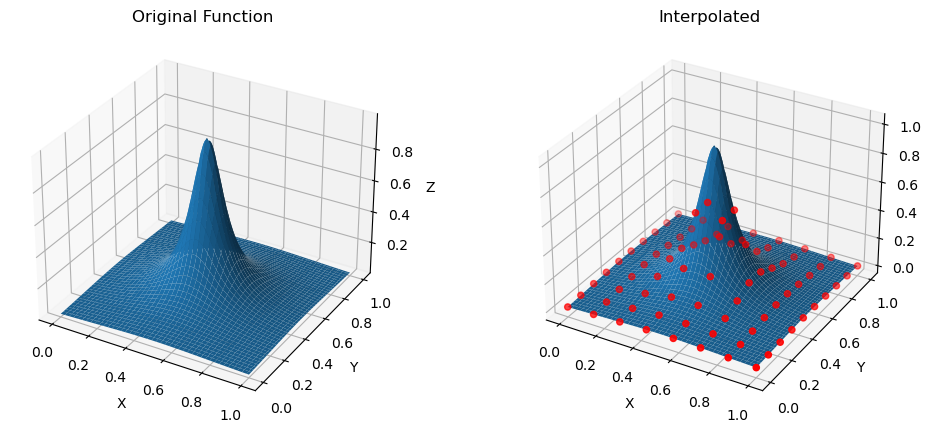

In [560]:
#PLOTS

fig = pyplot.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X,Y,F)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Original Function')
# ax1.view_init(elev=30)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Interpolated')

# ax2.plot_surface(X,Y,p,alpha = 0.4)
ax2.plot_surface(X,Y,F)
ax2.scatter(Qx,Qy,g(Qx,Qy), c='r', marker='o')
# ax2.view_init(elev=40)

# pyplot.tight_layout()
pyplot.show()

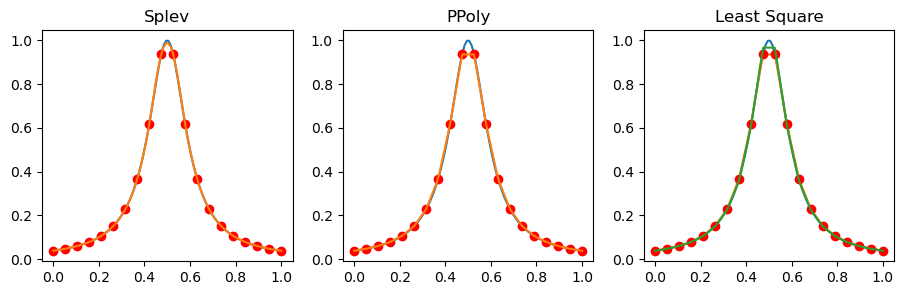

In [576]:
# Runge function
def f(x):
    return 1/(1+100*(x-.5)**2)

N = 100
M = 20

x = linspace(0,1, N)
q = linspace(0,1, M)
degree = 1

yq = f(q)

y = splev(x, splrep(q, yq))

B = zeros((N,M))
dB = zeros((N,M))
basis = []
dbasis = []

for i in range(M):
    c = q*0
    c[i] = 1
    bi = PPoly.from_spline(splrep(q,c,k=degree))

    B[:,i] = bi(x)
    dB[:,i] = bi.derivative(1)(x)
    
    basis.append(bi)
    dbasis.append(bi.derivative(1))
     
BtB = B.T.dot(B)
pL2 = linalg.solve(BtB, B.T.dot(f(x)))

# plot(x, B.dot(f(q)))
# plot(x, B.dot(pL2))
# plot(q, f(q), 'ro')
# plot(q, pL2, 'go')

fig, axes = subplots(1, 3, figsize=(11,3))

axes[0].plot(x, f(x))
axes[0].plot(q, yq,'ro')
axes[0].plot(x, y)
axes[0].set_title('Splev')

axes[1].plot(x, f(x))
axes[1].plot(q, yq, 'ro')
axes[1].plot(x, B.dot(f(q)))
axes[1].set_title('PPoly')

axes[2].plot(x, f(x))
axes[2].plot(x, B.dot(f(q)))
axes[2].plot(q, yq, 'ro')
axes[2].plot(x, B.dot(pL2))
# axes[2].plot(q, pL2, 'go')
axes[2].set_title('Least Square')

show()

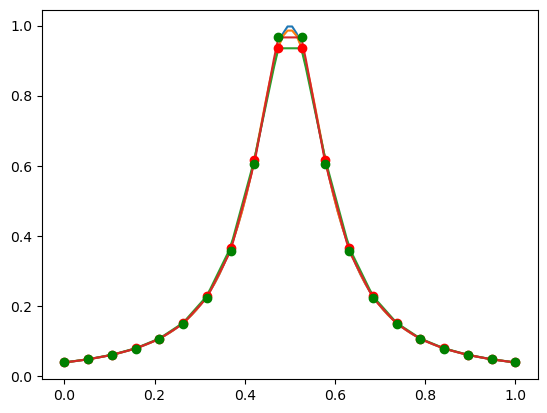

In [580]:
plot(x, f(x))
plot(x,y)
plot(x, B.dot(f(q)))
plot(x, B.dot(pL2))
plot(q, f(q), 'ro')
plot(q, pL2, 'go')